## Sprint9 ニューラルネットワーク

In [7]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


(60000,)
(60000, 10)
float64


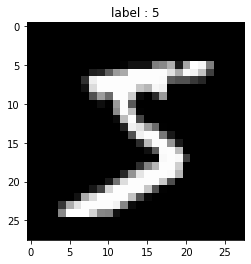

(60000, 784)
(10000, 784)
uint8
訓練データ全体 (60000, 784)
・入力値を０〜１の間に調整↓
1.0
0.0
・分割後の確認↓
(48000, 784)
(12000, 784)


In [17]:
# データ用意
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# * 正解ラベル→0から9の整数,NNの多クラス分類を行う際はone-hot表現に変換(0-1)
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)#ワンホットエンコードインスタンス化
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])#trainTransfrom
y_test_one_hot = enc.transform(y_test[:, np.newaxis])#testTransform

# データ確認
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

# 描画
index = 0
image = x_train[index]
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

# 2次元→1次元（画像データ→行データ）
# x_train = np.ravel(x_train)
# x_test = np.ravel(x_test)
# x_train = np.ravel(x_train)
# x_test = np.ravel(x_test)
# x_train = XXXXXXXXXXXXXXXXXXXXXXXXXXXXX
# x_test = XXXXXXXXXXXXXXXXXXXXXXXXXXXXX
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
print(x_train.shape)
print(x_test.shape)
print(x_train.dtype)
print("訓練データ全体",x_train.shape) 
# print("テストデータ全体",x_test.shape) 
# print("訓練データの1つのデータ",x_train[0].shape)
# print("訓練データの1つのデータの型",x_train[0].dtype) 


# NNの入力値にするため、Xのデータも0-1におさめる処理
x_train = x_train.astype(np.float)#2.365044290627876e-10
x_test = x_test.astype(np.float)#0.0

x_train /= 255
x_test /= 255
print('・入力値を０〜１の間に調整↓')
print(x_train.max()) 
print(x_train.min())


# 分割
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
print('・分割後の確認↓')
print(x_train.shape) # (48000, 784[2828])
print(x_test.shape) # (12000, 784)

In [18]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        """通常のコンストラクタと同様の働き
        Parameters
        ----------
        X : 説明変数（画像の1次元データ）
        y : 目的変数（ラベル）
        batch_size : 必要なミニバッチのデータ数
        seed : ランダムシード固定
        """
        # ランダムシードの固定（学習ごとに同じ生成順）
        np.random.seed(seed)
        # バッチ数のメンバ変数
        self.batch_size = batch_size
        # データ全体の長さ分のインデックスをランダムに並べ替え
        # np.random.permutation:配列をランダムに並べ替え
        # 歯抜け
        shuffle_index = np.random.permutation(self.batch_size)
        # print(shuffle_index)
        # shuffle_index = np.random.permutation(self.batch_size)
        # 並べ替えたインデックスと同じ順番で説明変数と目的変数を並べ替え
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        # データ数をバッチ数で割って、何回呼び出せば、全データを学習したことになるかの判定
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop
    
    def __iter__(self):
        # 何回目の呼び出しか
        self._counter = 0
        return self

    def __next__(self):
        # 全データを学習すればストップ
        if self._counter >= self._stop:
            raise StopIteration()
        # 並び変えた_X,_yの何番目のインデックスを採用するか
        # p0 = XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
        p0 = self._counter*self.batch_size + self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        # print(p0)
        # print(p1)
        # returnする前にカウンタに+1しておく
        self._counter += 1
        # 説明変数と目的変数を返す
        return self._X[p0:p1], self._y[p0:p1]
get_mini_batch = GetMiniBatch(x_train[:10000],y_train_one_hot[:10000], batch_size=20)

In [19]:

class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self,batch_size= 20,n_features= 784,n_nodes1= 400,n_nodes2= 200,n_output= 10,sigma= 0.02,lr= 0.01,epoch= 10, verbose=True):
        self.verbose = verbose#verbose : 計算過程を出力するか否か
        self.batch_size = batch_size#batch_size : ミニバッチのデータ数
        self.n_features = n_features#n_features : 説明変数の数
        self.n_nodes1 = n_nodes1#1層目のノードの数
        self.n_nodes2 = n_nodes2#2層目のノードの数 
        self.n_output = n_output#出力層のノードの数
        self.sigma = sigma#重みの初期化の際のガウス分布の標準偏差
        self.lr = lr#学習率
        self.epoch = epoch#学習回数（単位）
        # 損失記録用
        self.loss_train = []
        self.loss_test = []
        self.f_loss_list = []

        # 問題１
        # 使用する重みの初期化
        # 一層目の重みから三層目までの重みまで

        # 重み初期値
        # np.random.normal(0.0, pow(ニューロン数, -0.5), 行, 列)
        # 入力層→隠れ層→出力層にかけてニューロンがへる(ハイパーパラメーターで設定する))
        self.W1 = self.sigma * np.random.normal(0.0, pow(self.n_nodes1, -0.5), (self.n_features, self.n_nodes1))# (784, 400)
        self.W2 = self.sigma * np.random.normal(0.0, pow(self.n_nodes2, -0.5), (self.n_nodes1, self.n_nodes2))# (400, 200)
        self.W3 = self.sigma * np.random.normal(0.0, pow(self.n_output, -0.5), (self.n_nodes2, self.n_output))# (200, 10)
        # DICの歯抜けコードでは以下
        # self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)# (784, 400)
        # self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)# (400, 200)
        # self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)# (200, 10)

        # print(self.W1.shape)
        # print(self.W2.shape)
        # print(self.W3.shape)

        # 全て完成したら、W1〜W3までを以下の重み初期値に変えて実装してみる
        # self.W1 = np.ramdom.normal(0.0, pow(self.n_nodes1, -0.5), (self.n_nodes2, self.n_nodes1+1))
        # self.W2 = np.ramdom.normal(0.0, pow(self.n_nodes2, -0.5), (self.n_output, self.n_nodes2+1))
        # self.W3 = np.ramdom.normal(0.0, pow(self.n_nodes2, -0.5), (self.n_output, self.n_nodes2+1))

        self.B1 = self.sigma * np.random.randn(1, self.n_nodes1)# (1, 400)
        self.B2 = self.sigma * np.random.randn(1, self.n_nodes2)# (1, 200)
        self.B3 = self.sigma * np.random.randn(1, self.n_output)# (1, 10)

        # print(self.B1.shape)
        # print(self.B2.shape)
        # print(self.B3.shape)

        
    def fit(self, x, y, x_test=None, y_test=None):
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        ----------
        x : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        x_test : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_test : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # 学習回数分ループ
        for _ in range(self.epoch):
            
            # 先ほど定義したミニバッチイテレータのインスタンス化
            # self._counter*self.batch_size + self.batch_size
            get_mini_batch = GetMiniBatch(x, y, batch_size=20)
            # get_mini_batch = GetMiniBatch(x_train, y_train, batch_size=20)
            
            # ミニバッチイテレータが停止するまでバッチ学習
            # get_mini_batchを呼び出すたびに、説明変数と目的変数が返ってくる
            for mini_x_train, mini_y_train in get_mini_batch:
                # 順伝播
                self.forward_propagation(mini_x_train)
                # 逆伝播
                self.backward_propagation(mini_x_train, mini_y_train)
                
            # ミニバッチ学習後のロス計算
            self.forward_propagation(x)
            # loss = self.Z3 - y
            # self.f_loss_list.append(loss[-1])
            # print(self.cross_entropy_error(y, self.Z3))
            self.loss_train.append(self.cross_entropy_error(y, self.Z3))
            # 評価データがあるなら、こちらも計算
            if x_test is not None:
                self.forward_propagation(x_test)
                self.loss_test.append(self.cross_entropy_error(y_test, self.Z3))
        
        # 学習過程の出力
        if self.verbose:
            if x_test is None:
                print(self.loss_train)
            else:
                print(self.loss_train,self.loss_test)

    # 問題２ ゼロつく58ページ参照
    # 入力層から出力層まで
    def forward_propagation(self, x):
        """順伝播
        Parameters
        ----------
        x : 説明変数
        """
        # X1 = np.array(np.append(x, [1]),ndmin=2).T
        ## 1層目
        self.A1 = x @ self.W1 + self.B1
        self.Z1 = self.tanh_function(self.A1)
        
        ## 2層目
        self.A2 = self.Z1 @ self.W2 + self.B2
        # self.Z2 = self.tanh_function(self.A2)
        self.Z2 = self.sigmoid(self.A2)
        
        ## 3層目（出力層）
        self.A3 = self.Z2 @ self.W3 + self.B3
        self.Z3 = self.softmax(self.A3)
        # ※活性化関数の違いを要復習
        # メンバ変数self.Z3がNNの出力となる
        # print(self.Z3)
        return self.Z3

        # # 問題４
    def backward_propagation(self, x, y):
        """逆順伝播
        Parameters
        ----------
        x : 説明変数
        """
        ## 3層目（出力層）
        # 3層目の重みに対する勾配
        # self.Z3＝forward_propagationの出力値
        
        # print(y)
        dA3 = self.forward_propagation(x) - y
        # dA3 = self.Z3 - y
        dW3 = self.Z2.T @ dA3
        # 3層目のバイアス項に対する勾配
        dB3 = np.sum(dA3, axis=0)
        
        ## 2層目
        # 2層目の重みに対する勾配
        dZ2 = dA3 @ self.W3.T
        dA2 = dZ2 * (1 - self.tanh_function(self.A2)**2)
        dW2 = self.Z1.T @ dA2
        # 2層目のバイアス項に対する勾配
        dB2 = np.sum(dA2, axis=0)
        
        ## 1層目
        # 1層目の重みに対する勾配
        dZ1 = dA2 @ self.W2.T
        dA1 = dZ1 * (1 - self.tanh_function(self.A1)**2)
        dW1 = x.T @ dA1
        # 1層目のバイアス項に対する勾配
        dB1 = np.sum(dA1, axis=0)
        
        # 問題4
        # バックプロパゲーションの更新式
        self.W3 -= self.lr * dW3
        self.B3 -= self.lr * dB3
        self.W2 -= self.lr * dW2
        self.B2 -= self.lr * dB2
        self.W1 -= self.lr * dW1
        self.B1 -= self.lr * dB1
    
    # 問題２
    def tanh_function(self, A):
        """活性化関数tanh
        Parameters
        ----------
        A : ndarray
        """
        return np.tanh(A)

    # 問題２
    def softmax(self, A):
        """活性化関数softmax
        Parameters
        ----------
        A : ndarray
        """
        # オーバーフロー対策の場合のコード
        # a_max = np.max(A)
        # exp_a = np.exp(A - a_max)

        # exp_a = np.exp(A)
        # sum_exp_a = np.sum(exp_a, axis=1)
        # s = exp_a / sum_exp_a
        return np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)#s.reshape(-1, 1)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    # 問題３
    def cross_entropy_error(self, y, Z):
        """損失関数 交差エントロピー誤差
        Parameters
        ----------
        y : 正解データ
        Z : 予測値
        """
        # if y.ndim == 1:
        #     Z = reshape(1, Z.size)
        #     y = reshape(1, y.size)
        # delta = 1e-7
        # batch_s = y.shape[0]
        # an = -np.sum(Z * np.log(y + delta)) / batch_s
        # バッチサイズ＝yでわる
        # error = -np.sum(Z * np.log(y + delta))
        L = - np.sum(y * np.log(Z)) / len(y)
        return L#an

    def predict(self, x):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        x : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
                # 順伝播処理
        # self.forward(X)
        self.forward_propagation(x)
        # 最も大きいインデックスをクラスとして採用
        return np.argmax(self.Z3, axis=1)
        
# X = np.array([np.concatenate([1], v) for v in x_train])
# X1 = np.array(np.append(x_train, [1]),ndmin=2).T
# print(X1.shape)
# print(X1)#(47040001, 1)
# print(X.shape)
# print(X)

In [20]:
# インスタンス化
nn = ScratchSimpleNeuralNetrowkClassifier(batch_size= 20,n_features= 784,n_nodes1= 400,n_nodes2= 200,n_output= 10,sigma= 0.02,lr= 0.01,epoch= 15, verbose=True)
# print(nn.forward_propagation(x_train[:10000]))
# print(nn.backward_propagation(x_train[:10000], y_train_one_hot[:10000]))
# 学習
nn.fit(x_train[:10000],y_train_one_hot[:10000], x_test[:10000], y_test_one_hot)
# # nn.fit(x_train[:10000],y_train_one_hot[:10000], x_test, y_test_one_hot)
# 予測
pred_train = nn.predict(x_train)
pred_test = nn.predict(x_test)
print(pred_train)
print(pred_test)

[2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718] [2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446]
[9 9 9 ... 9 9 9]
[9 9 9 ... 9 9 9]


## 問題６

In [28]:
# print(y_train)
# print(pred_train)
# print(y_test)
# print(pred_test)
print(y_train_one_hot.shape)
print(pred_train.shape)
# print(y_train.shape)
# print(y_test.shape)
print(y_test_one_hot.shape)
print(pred_test.shape)
print(f'正解率 : \n y_train: {accuracy_score(y_train, pred_train)},\n y_test : {accuracy_score(y_test, pred_test)}')

# 初期値変更前 (0.09935416666666666, 0.09833333333333333)
# 初期値変更後 (0.09935416666666666, 0.098333333333333339)

(60000, 10)
(48000,)
(10000, 10)
(12000,)
正解率 : 
 y_train: 0.09883333333333333,
 y_test : 0.10041666666666667


[2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718, 2.302387281693718]
[2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446, 2.3022933462241446]


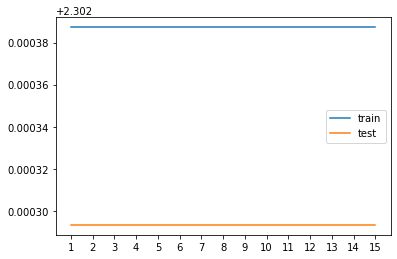

In [30]:
# print(list(range(1, nn.epoch+1)))
print(nn.loss_train)
print(nn.loss_test)
# print(nn.f_loss_list[0])

# plt.plot(list(range(1, nn.epoch+1)), nn.f_loss_list, label='train')
plt.plot(list(range(1, nn.epoch+1)), nn.loss_train, label='train')
plt.plot(list(range(1, nn.epoch+1)), nn.loss_test, label='test')
plt.legend()
plt.xticks(list(range(1, nn.epoch+1)));